# Gravity Survey Problem

<img src="gravity_survey.PNG" style="width:600px;float:left">

상기 그림에서 $f(t)$는 지표면에서 d만큼 아래에서의 질량밀도이다. t축 상에서 0~1 구간에 질량이 분포해 있으며, 이 질량분포로 인해 중력장이 발생한다. 지표면 s에서 수직방향의 중력장 $g(s)$를 측정한다. 

t 지점과 s점 사이의 거리 r은 다음과 같다.

$r = \sqrt{d^2 + (s-t)^2}$

미소길이 $dt$에 위치한 질량분포 $f(t)$에 의해 지표면 s에서 발생하는 수직방향 중력장은 다음과 같다.

$\large \frac{sin\theta f(t)dt}{r^2}=\frac{d}{(d^2+(s-t)^2)^{3/2}}f(t)$

상기 식을 t의 전구간 [0,1]에 대해 적분하면 다음과 같다.

$g(s)= \int_0^1  \frac{d}{(d^2+(s-t)^2)^{3/2}} f(t) dt$

상기 식을 다음과 같이 일반화 할 수 있으며 이러한 형태를 First-kind Fredholm integral equation이라고 한다.

$\int K(s,t) f(t) dt = g(s)$

In [1]:
def K(s,t): return d/pow(d**2+(s-t)**2,3/2)

## (1) Forward Problem

다음과 같은 질량분포가 주어졌다고 하자.

In [2]:
from numpy import *
from matplotlib.pyplot import *
from numpy.linalg import *

In [3]:
def f(t): return sin(pi*t)+0.5*sin(2*pi*t)

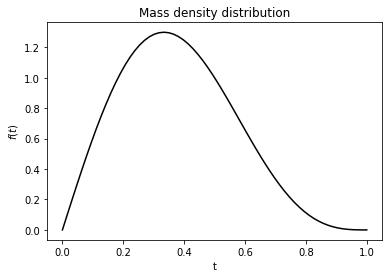

In [4]:
n = 64; t = linspace(0,1,n)
plot(t,f(t),'k'); xlabel('t'); ylabel('$f(t)$'); title('Mass density distribution');

$f(t)$와 $K(s,t)$를 알고 있으므로 $g(s)$를 계산할 수 있다. 계산을 위해 Quadrature Method (midpoint rule)을 적용해 이산화를 수행하여 AX=b의 선형대수 형태로 변형하고 b를 계산한다.

In [5]:
def Q(K,f,n=64,a=0,b=1):
    j = arange(n)+1
    t = a+(b-a)*(j-0.5)/n
    s = t
    w = (b-a)/n
    A = zeros([n,n])
    for i in range(n):
        for j in range(n):
            A[i,j] = w * K(s[i],t[j])
    x = zeros(n)
    for i in range(n):
        x[i] = f(t[i])
    b = A@x
    
    return A,x,b

깊이 d=0.25,0.5,1.0 일 때 수직성분 중력장을 계산해보면 다음과 같다.

In [6]:
d=0.25 ; A,x,b1 = Q(K,f,n=64)
d=0.50 ; _,_,b2 = Q(K,f,n=64)
d=1.00 ; _,_,b3 = Q(K,f,n=64)

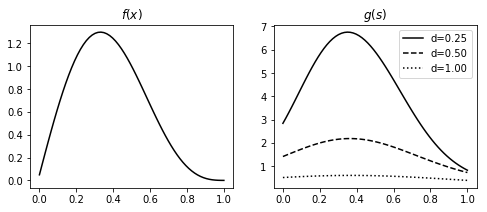

In [7]:
figure(figsize=(8,3))
subplot(121);    plot(t,x,'k');  title('$f(x)$')
subplot(122);    plot(t,b1,'k-',label='d=0.25'); plot(t,b2,'k--',label='d=0.50'); plot(t,b3,'k:',label='d=1.00'); 
title('$g(s)$'); legend(loc='upper right');

깊이가 깊을 수록 중력장이 약해짐을 볼 수 있다. 또한 질량밀도분포와 유사한 형태의 중력장이 형성됨을 볼 수 있다.

## (2) Inverse Problem

측정한 중력장을 통해 질량밀도를 예측하는 역방향 문제를 고려해보자.

A, b가 주어진 경우 x를 찾는 문제가 된다. x는 다음과 같이 최소자승법을 사용해 구할 수 있다.

$x = (A^TA)^{-1}A^Tb$

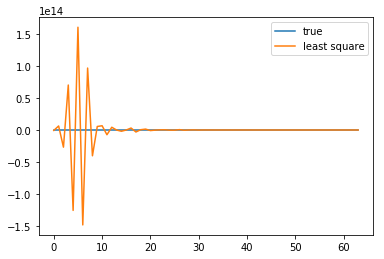

In [8]:
x_ls = inv(A.T@A)@A.T@b1; plot(x,label='true'); plot(x_ls,label='least square'); legend();

이상한 결과가 나온다. 이는 A가 Ill-conditioned이기 때문이다.

In [9]:
cond(A)

1.4618907922884215e+19

아래 식과 같이 Tikhonov Regularization을 적용해 보자. 

$x = (A^TA+\lambda^2I)^{-1}A^Tb$

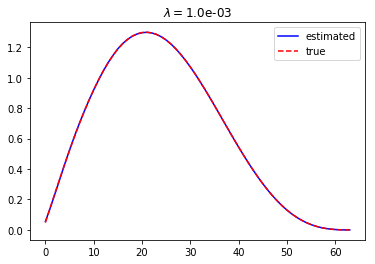

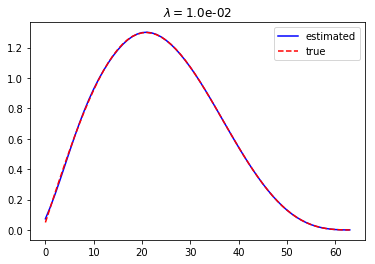

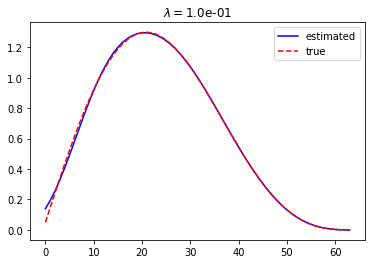

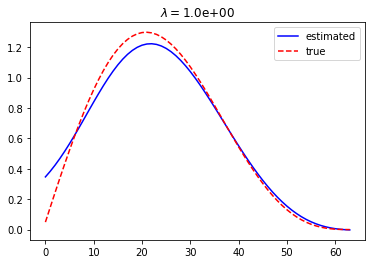

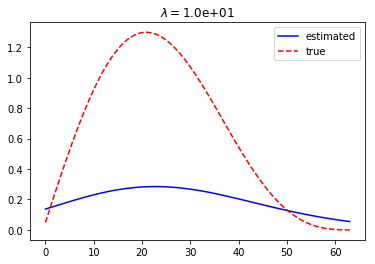

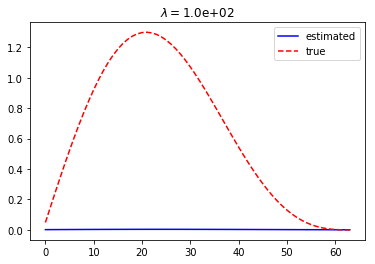

In [10]:
lam = array([1e-3,1e-2,1e-1,1e0,1e1,1e2])

for i in range(len(lam)):
    x_tik = inv(A.T@A+(lam[i]**2)*identity(len(b1)))@A.T@b1
    figure(); plot(x_tik,'b-',label='estimated');plot(x,'r--',label='true'); legend(); title('$\lambda=$%.1e'%(lam[i]));

$\lambda$가 적절히 선택되면 좋은 결과가 계산된다. $b$에 노이즈를 추가해도 Tikhonov Regularization이 잘되는지 해보자.

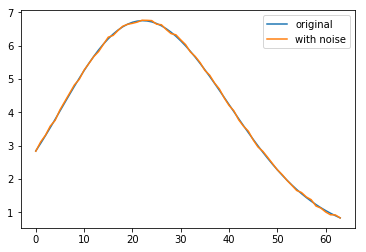

In [11]:
b_wn = b1 + 0.1*(random.rand(len(b1))-0.5); plot(b1,label='original'); plot(b_wn,label='with noise'); legend();

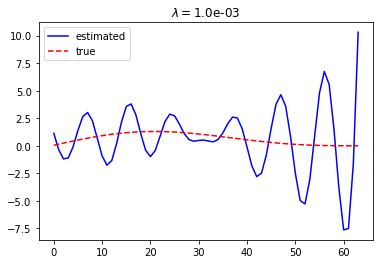

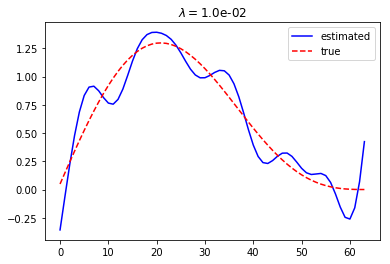

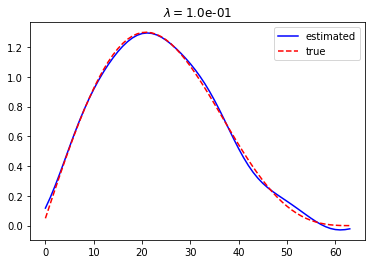

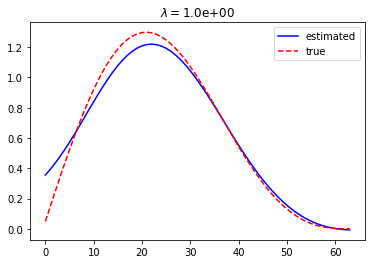

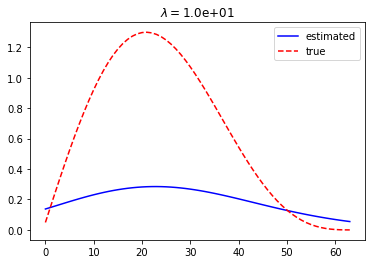

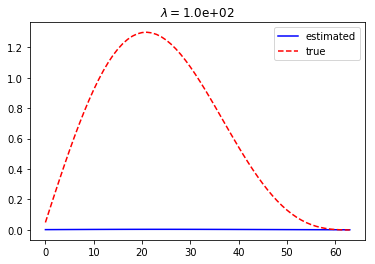

In [12]:
lam = array([1e-3,1e-2,1e-1,1e0,1e1,1e2])

for i in range(len(lam)):
    x_tik = inv(A.T@A+(lam[i]**2)*identity(len(b_wn)))@A.T@b_wn
    figure(); plot(x_tik,'b-',label='estimated');plot(x,'r--',label='true'); legend(); title('$\lambda=$%.1e'%(lam[i]));

$\lambda$가 1 근처면 잘 예측되는 듯 하다.

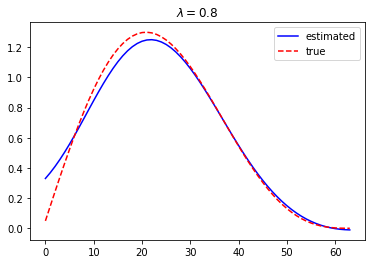

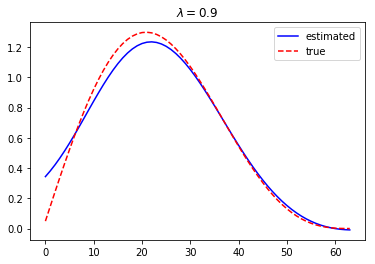

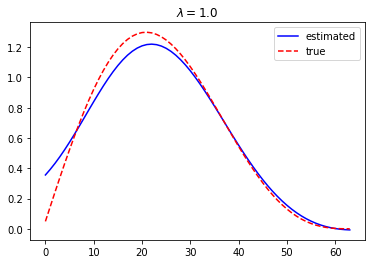

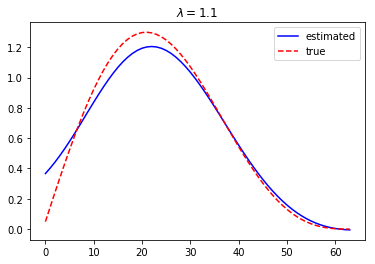

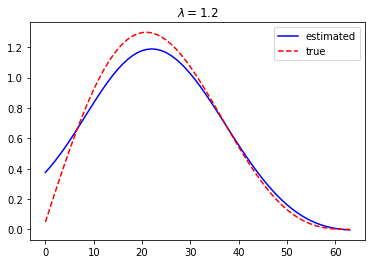

In [13]:
lam = array([0.8, 0.9, 1, 1.1, 1.2])

for i in range(len(lam)):
    x_tik = inv(A.T@A+(lam[i]**2)*identity(len(b_wn)))@A.T@b_wn
    figure(); plot(x_tik,'b-',label='estimated');plot(x,'r--',label='true'); legend(); title('$\lambda=$%.1f'%(lam[i]));

어떤 $\lambda$가 최적의 값일까? 여러가지 방법이 있지만 L-Curve로 간단히 확인해보기로 하자

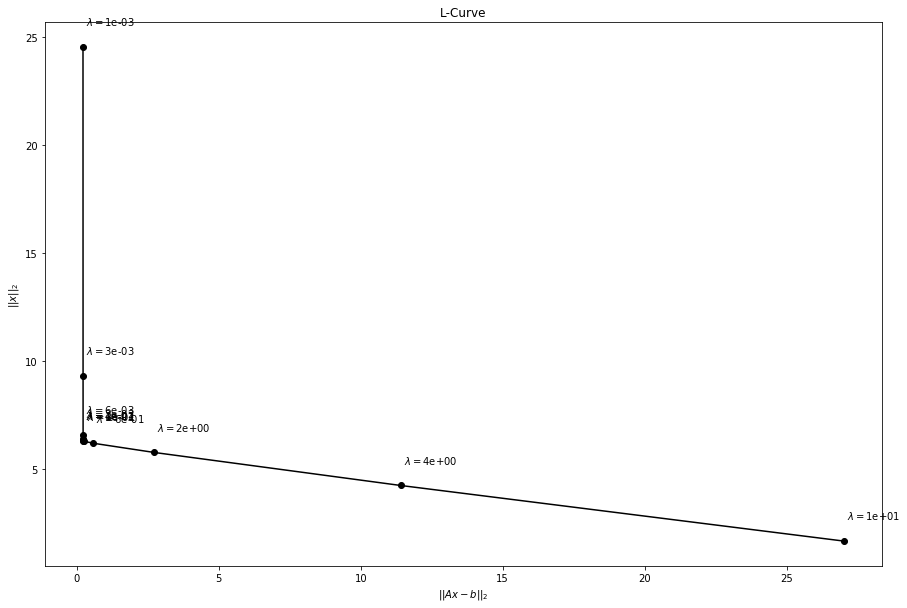

In [14]:
from scipy.linalg import norm
lam = pow(10,linspace(-3,1,11))
row = len(b_wn); col = len(lam); x_tik = zeros([row,col])
solu_norm,resi_norm = zeros(col),zeros(col)
for i in range(len(lam)):
    x_tik[:,i] = inv(A.T@A+(lam[i]**2)*identity(len(b_wn)))@A.T@b_wn
    solu_norm[i] = norm(x_tik[:,i])
    resi_norm[i] = norm(A@x_tik[:,i]-b_wn)
figure(figsize=(15,10))
plot(resi_norm,solu_norm,'ko-'); title('L-Curve'); xlabel('$||Ax-b||_2$'); ylabel('$||x||_2$'); 
for i in range(len(lam)):
    text(resi_norm[i]+0.1,solu_norm[i]+1,'$\lambda=$%.0e'%(lam[i]));

모서리 부분을 확대해보자

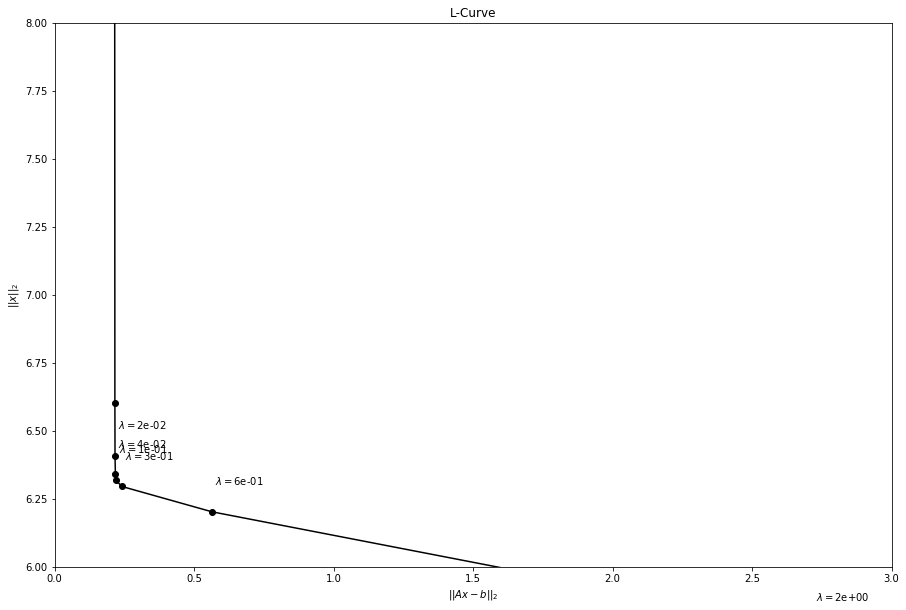

In [15]:
figure(figsize=(15,10))
plot(resi_norm,solu_norm,'ko-'); title('L-Curve'); xlabel('$||Ax-b||_2$'); ylabel('$||x||_2$'); xlim(0,3); ylim(6,8);
for i in range(3,9):
    text(resi_norm[i]+0.01,solu_norm[i]+0.1,'$\lambda=$%.0e'%(lam[i]));

$\lambda=3e-01$이 최적의 값인 듯 하다.

In [16]:
lam

array([1.00000000e-03, 2.51188643e-03, 6.30957344e-03, 1.58489319e-02,
       3.98107171e-02, 1.00000000e-01, 2.51188643e-01, 6.30957344e-01,
       1.58489319e+00, 3.98107171e+00, 1.00000000e+01])

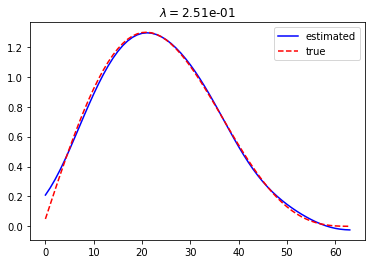

In [17]:
lam = 2.51188643e-01
x_tik = inv(A.T@A+(lam**2)*identity(len(b_wn)))@A.T@b_wn
figure(); plot(x_tik,'b-',label='estimated');plot(x,'r--',label='true'); legend(); title('$\lambda=$%.2e'%(lam));

잘맞는다..ㅎ